#  XGBoost model. Full dataset. AWS

In [4]:
import pandas as pd
import numpy as np
import timeit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from collections import OrderedDict
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

In [5]:
all = pd.read_csv('merged1.csv')
dept = pd.read_csv('mer_products.csv')

In [6]:
all.user_id[all.eval_set == 'train'].unique().shape

(131209,)

In [7]:
all.user_id[all.eval_set == 'prior'].unique().shape

(206209,)

In [8]:
order_products_train = all[all.eval_set == 'train']
order_products_prior = all[all.eval_set == 'prior']

In [9]:
train_ids = order_products_train['user_id'].unique()
order_products_prior = order_products_prior[order_products_prior['user_id'].isin(
    train_ids)]

In [10]:
dept1 = dept.copy()
dept1 = dept1[['product_id', 'aisle_id', 'department_id']]
order_products_prior = pd.merge(order_products_prior, dept1, on=['product_id'])

In [11]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 0 to 33819105
Data columns (total 10 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   order_id         1384617 non-null  int64  
 1   product_id       1384617 non-null  int64  
 2   add_cart_order   1384617 non-null  int64  
 3   reordered        1384617 non-null  int64  
 4   user_id          1384617 non-null  int64  
 5   eval_set         1384617 non-null  object 
 6   order_number     1384617 non-null  int64  
 7   order_dow        1384617 non-null  int64  
 8   order_hour       1384617 non-null  int64  
 9   days_last_order  1384617 non-null  float64
dtypes: float64(1), int64(8), object(1)
memory usage: 116.2+ MB


In [12]:
order_products_train.nunique()

order_id           131209
product_id          39123
add_cart_order         80
reordered               2
user_id            131209
eval_set                1
order_number           97
order_dow               7
order_hour             24
days_last_order        31
dtype: int64

In [13]:
order_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20641991 entries, 0 to 20641990
Data columns (total 12 columns):
 #   Column           Dtype  
---  ------           -----  
 0   order_id         int64  
 1   product_id       int64  
 2   add_cart_order   int64  
 3   reordered        int64  
 4   user_id          int64  
 5   eval_set         object 
 6   order_number     int64  
 7   order_dow        int64  
 8   order_hour       int64  
 9   days_last_order  float64
 10  aisle_id         int64  
 11  department_id    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 2.0+ GB


In [14]:
# imputing null values in the first order
order_products_prior.fillna(order_products_prior.days_last_order.mean(), inplace=True)

In [15]:
order_products_prior.isna().sum()

order_id           0
product_id         0
add_cart_order     0
reordered          0
user_id            0
eval_set           0
order_number       0
order_dow          0
order_hour         0
days_last_order    0
aisle_id           0
department_id      0
dtype: int64

In [16]:
insta = order_products_prior[['product_id', 'user_id']].drop_duplicates()

In [17]:
insta.shape

(8474661, 2)

In [18]:
insta.user_id.unique().shape

(131209,)

In [19]:
# converting into binary classification problem
train_carts = (order_products_train.groupby('user_id', as_index=False)
                                   .agg({'product_id': (lambda x: set(x))})
                                   .rename(columns={'product_id': 'latest_cart'}))

insta = insta.merge(train_carts, on='user_id')
insta['in_cart'] = (insta.apply(lambda row: row['product_id']
                                in row['latest_cart'], axis=1).astype(int))
print(insta.sample(1))
print(insta.shape)

         product_id  user_id  \
4400236       21195    81206   

                                               latest_cart  in_cart  
4400236  {42562, 27238, 33095, 45066, 22667, 32684, 267...        0  
(8474661, 4)


In [20]:
def get_user_split_data(df, test_size=.20, seed=42):

    rs = np.random.RandomState(seed)

    total_users = df['user_id'].unique()
    test_users = rs.choice(total_users,
                           size=int(total_users.shape[0] * test_size),
                           replace=False)
    df_te = df[df['user_id'].isin(test_users)]

    df_val_tr = df[~df['user_id'].isin(test_users)]

    val_tr_users = df_val_tr['user_id'].unique()

    val_users = (rs.choice(val_tr_users,
                           size=int(val_tr_users.shape[0] * test_size),
                           replace=False))

    df_tr = df_val_tr[~df_val_tr['user_id'].isin(val_users)]

    df_val = df_val_tr[df_val_tr['user_id'].isin(val_users)]

    y_tr, y_te, y_val = df_tr['in_cart'], df_te['in_cart'], df_val['in_cart']
    X_tr = df_tr.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_te = df_te.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_val = df_val.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    return X_tr, X_te, X_val, y_tr, y_te, y_val

# Feature Engineering

## Product / Department / Aisle features

In [21]:
p_features_names = ['p_total_orders', 'p_avg_add_cart_order']

p_features = (order_products_prior.groupby(['product_id'], as_index=False)
              .agg(OrderedDict(
                  [('order_id', 'nunique'),
                   ('add_cart_order', 'mean')])))
p_features.columns = ['product_id'] + p_features_names
p_features.sample(1)

,product_id,p_total_orders,p_avg_add_cart_order
26161,26263,3,3.0


In [22]:
p_features.shape

(49468, 3)

In [23]:
# product average day of week ordered
p_dow = order_products_prior.groupby(
    ['product_id'])[['order_dow']].mean().reset_index()
p_dow.columns = ['product_id', 'p_order_dow']
p_features = pd.merge(p_features, p_dow, on=['product_id'], how='left')
p_features.sample(1)

,product_id,p_total_orders,p_avg_add_cart_order,p_order_dow
15974,16037,3,12.0,3.0


In [24]:
p_features.shape

(49468, 4)

In [25]:
# product average hour ordered
p_hour = order_products_prior.groupby(
    ['product_id'])[['order_hour']].mean().reset_index()
p_hour.columns = ['product_id', 'p_order_hour']
p_features = pd.merge(p_features, p_hour, on=['product_id'], how='left')
p_features.head()

,product_id,p_total_orders,p_avg_add_cart_order,p_order_dow,p_order_hour
0,1,1202,5.647255,2.782030,13.104825
1,2,60,10.766667,3.116667,13.016667
2,3,193,6.378238,2.611399,12.321244
3,4,218,9.788991,2.619266,13.591743
4,5,12,5.416667,2.916667,11.166667


In [26]:
# product reorder rate
reordered = order_products_prior.groupby(
    ['product_id'])[['reordered']].sum().reset_index()
reordered.columns = ['product_id', 'reorder_sum']
p_features = pd.merge(p_features, reordered, on=['product_id'], how='left')
p_features['p_reorder_rate'] = p_features.reorder_sum/p_features.p_total_orders

In [27]:
p_features.shape

(49468, 7)

In [28]:
# aisle reorder rate
opp_a = order_products_prior[['product_id', 'aisle_id']].drop_duplicates()
opp_a.sample(1)
p_features = pd.merge(p_features, opp_a, how='left', on=['product_id'])
reordered_a = order_products_prior.groupby(
    ['aisle_id'])[['reordered']].mean().reset_index()
reordered_a.columns = ['aisle_id', 'a_reorder_rate']
p_features = pd.merge(p_features, reordered_a, how='left', on='aisle_id')
p_features.drop(['aisle_id'], axis=1, inplace=True)

In [29]:
# department reorder rate
opp_d = order_products_prior[['product_id', 'department_id']].drop_duplicates()
opp_d.sample(1)
p_features = pd.merge(p_features, opp_d, how='left', on=['product_id'])
reordered_d = order_products_prior.groupby(
    ['department_id'])[['reordered']].mean().reset_index()
reordered_d.columns = ['department_id', 'd_reorder_rate']
print(reordered_d.shape)
p_features = pd.merge(p_features, reordered_d, how='left', on='department_id')
p_features.drop(['department_id'], axis=1, inplace=True)

(21, 2)


In [30]:
p_features.shape

(49468, 9)

In [31]:
insta = insta.merge(p_features, on='product_id')
print(insta.sample(1))

         product_id  user_id     latest_cart  in_cart  p_total_orders  \
8369172       13453    46992  {45113, 14233}        0              64   

         p_avg_add_cart_order  p_order_dow  p_order_hour  reorder_sum  \
8369172                8.6875     3.234375     13.671875           13   

         p_reorder_rate  a_reorder_rate  d_reorder_rate  
8369172        0.203125        0.305992         0.34608  


## User features

In [32]:
u_features_names = ['u_total_orders', 'u_avg_cartsize',
                    'u_total_products', 'u_avg_days_since_prior_order']

u_features = (order_products_prior.groupby(['user_id'], as_index=False)
              .agg(OrderedDict(
                  [('order_id', ['nunique', (lambda x: x.shape[0] / x.nunique())]),
                   ('product_id', 'nunique'),
                   ('days_last_order', 'mean')])))

u_features.columns = ['user_id'] + u_features_names
print(u_features.sample(1))
print(u_features.shape)

        user_id  u_total_orders  u_avg_cartsize  u_total_products  \
121804   191341              11            14.0                71   

        u_avg_days_since_prior_order  
121804                     16.405695  
(131209, 5)


In [33]:
# user's TRAIN order - dow and hour info
u_train_dow_hour = order_products_train[['user_id', 'order_dow', 'order_hour']]

u_train_dow_hour.drop_duplicates(inplace=True)

u_train_dow_hour.columns = ['user_id', 'u_train_order_dow', 'u_train_hour']

u_features = pd.merge(u_features, u_train_dow_hour, on='user_id', how='left')

/home/ubuntu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [34]:
insta = insta.merge(u_features, on='user_id', how='left')

## User-Product/Department features

In [35]:
#u_p total orders
u_p_features = (order_products_prior.groupby(['product_id', 'user_id'], as_index=False)
                .agg({'order_id': 'count'})
                .rename(columns={'order_id': 'u_p_total_orders'}))
u_p_features.sample(1)

,product_id,user_id,u_p_total_orders
6032302,35898,184065,3


In [36]:
#u_p add cart order
u_p_features['u_p_avg_add_to_cart_order'] = (order_products_prior.groupby(['product_id', 'user_id'], as_index=False)
                                             .agg(OrderedDict(
                                                 [('add_cart_order', 'mean')]))['add_cart_order'])
order_products_prior.sample(2)

,order_id,product_id,add_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour,days_last_order,aisle_id,department_id
3797533,2063857,5876,7,1,206053,prior,44,5,14,3.0,24,4
16628141,897689,30839,9,0,8886,prior,3,6,11,30.0,129,1


In [37]:
# u_p order rate
u_p_num_ordered = order_products_prior.groupby(['user_id', 'product_id'], as_index=False)[
    ['order_id']].count()
u_p_num_ordered.columns = ['user_id', 'product_id', 'u_p_num_ordered']
u_p_features = pd.merge(u_p_features, u_p_num_ordered, on=[
                        'user_id', 'product_id'], how='left')
tot_orders = order_products_prior.groupby(
    'user_id', as_index=False)[['order_number']].max()
tot_orders.columns = ['user_id', 'user_total_orders']
u_p_features = pd.merge(u_p_features, tot_orders, on='user_id', how='left')
u_p_features['u_p_order_rate'] = u_p_features['u_p_num_ordered'] / \
    u_p_features['user_total_orders']
u_p_features.head(2)

,product_id,user_id,u_p_total_orders,u_p_avg_add_to_cart_order,u_p_num_ordered,user_total_orders,u_p_order_rate
0,1,138,2,3.0,2,32,0.0625
1,1,709,1,20.0,1,5,0.2000


In [38]:
# user dept order rate

u_d_num_ordered = order_products_prior.groupby(['user_id', 'department_id'], as_index=False)[
    ['order_id']].count()
u_d_num_ordered.columns = ['user_id', 'department_id', 'u_d_num_ordered']
u_d_num_ordered = pd.merge(u_d_num_ordered, tot_orders, on='user_id')
u_d_num_ordered['u_d_order_rate'] = u_d_num_ordered.u_d_num_ordered / \
    u_d_num_ordered.user_total_orders
u_d_order_rate = u_d_num_ordered.drop(
    ['u_d_num_ordered', 'user_total_orders'], axis=1)
opp_u_d = order_products_prior[[
    'user_id', 'product_id', 'department_id']].drop_duplicates()

In [39]:
u_d_features = pd.merge(opp_u_d, u_d_order_rate, on=[
                        'user_id', 'department_id'])
u_d_features.sample(1)

,user_id,product_id,department_id,u_d_order_rate
7561026,159549,1200,15,0.232323


In [40]:
# last order number and number of orders since last purchase
last_order = order_products_prior.groupby(['user_id', 'product_id'], as_index=False)[
    ['order_number']].max()
last_order.columns = ['user_id', 'product_id', 'u_p_last_order_number']
u_p_features = pd.merge(u_p_features, last_order, on=[
                        'user_id', 'product_id'], how='left')
u_p_features['u_p_orders_since_last_purch'] = u_p_features['user_total_orders'] - \
    u_p_features['u_p_last_order_number']
u_p_features['u_p_in_last_order'] = (
    u_p_features['u_p_orders_since_last_purch'] == 1).astype(int)

In [41]:
# u_p average day of week ordered
u_p_dow = order_products_prior.groupby(['product_id', 'user_id'], as_index=False)[
    ['order_dow']].mean()
u_p_dow.columns = ['product_id', 'user_id', 'u_p_order_dow']
u_p_features = pd.merge(u_p_features, u_p_dow, on=[
                        'product_id', 'user_id'], how='left')
u_p_features.sample(1)

,product_id,user_id,u_p_total_orders,u_p_avg_add_to_cart_order,u_p_num_ordered,user_total_orders,u_p_order_rate,u_p_last_order_number,u_p_orders_since_last_purch,u_p_in_last_order,u_p_order_dow
3767919,22952,5639,2,5.5,2,62,0.032258,22,40,0,1.5


In [42]:
u_p_hour = order_products_prior.groupby(['product_id', 'user_id'], as_index=False)[
    ['order_hour']].mean()
u_p_hour.columns = ['product_id', 'user_id', 'u_p_order_hour']
u_p_features = pd.merge(u_p_features, u_p_hour, on=[
                        'product_id', 'user_id'], how='left')
u_p_features.sample(1)

,product_id,user_id,u_p_total_orders,u_p_avg_add_to_cart_order,u_p_num_ordered,user_total_orders,u_p_order_rate,u_p_last_order_number,u_p_orders_since_last_purch,u_p_in_last_order,u_p_order_dow,u_p_order_hour
3640148,22218,5377,10,7.1,10,81,0.123457,78,3,0,3.9,13.7


In [43]:
# merging u_p_features with insta
insta = insta.merge(u_p_features, on=['user_id', 'product_id'])
insta = insta.merge(u_d_features, on=['user_id', 'product_id'])

#insta['u_p_order_freq'] = insta['u_p_total_orders'] / insta['user_total_orders']
insta['u_p_delta_hour'] = insta.u_p_order_hour - insta.u_train_hour
insta['u_p_delta_dow'] = insta.u_p_order_dow - insta.u_train_order_dow
insta['p_delta_hour'] = insta.p_order_hour - insta.u_train_hour
insta['p_delta_dow'] = insta.p_order_dow - insta.u_train_order_dow

insta.drop(['u_p_order_hour', 'p_order_hour', 'u_p_order_dow', 'p_order_dow', 'u_train_hour',
            'u_train_order_dow', 'reorder_sum',  'user_total_orders','u_p_num_ordered', 
            'u_p_last_order_number','department_id'], axis=1, inplace=True)


In [44]:
insta.shape

(8474661, 23)

In [45]:
print(insta.columns, '\n', len(insta.columns))

Index(['product_id', 'user_id', 'latest_cart', 'in_cart', 'p_total_orders',
       'p_avg_add_cart_order', 'p_reorder_rate', 'a_reorder_rate',
       'd_reorder_rate', 'u_total_orders', 'u_avg_cartsize',
       'u_total_products', 'u_avg_days_since_prior_order', 'u_p_total_orders',
       'u_p_avg_add_to_cart_order', 'u_p_order_rate',
       'u_p_orders_since_last_purch', 'u_p_in_last_order', 'u_d_order_rate',
       'u_p_delta_hour', 'u_p_delta_dow', 'p_delta_hour', 'p_delta_dow'],
      dtype='object') 
 23


# Modeling

In [46]:
# splitting the data into test, val, train subsets function
def get_user_split_data(df, test_size=.20, seed=42):

    rs = np.random.RandomState(seed)

    total_users = df['user_id'].unique()
    test_users = rs.choice(total_users,
                           size=int(total_users.shape[0] * test_size),
                           replace=False)
    df_te = df[df['user_id'].isin(test_users)]
    df_val_tr = df[~df['user_id'].isin(test_users)]
    val_tr_users = df_val_tr['user_id'].unique()
    val_users = (rs.choice(val_tr_users,
                           size=int(val_tr_users.shape[0] * test_size),
                           replace=False))

    df_tr = df_val_tr[~df_val_tr['user_id'].isin(val_users)]
    df_val = df_val_tr[df_val_tr['user_id'].isin(val_users)]
    y_tr, y_te, y_val = df_tr['in_cart'], df_te['in_cart'], df_val['in_cart']
    X_tr = df_tr.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_te = df_te.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    X_val = df_val.drop(
        ['product_id', 'user_id', 'latest_cart', 'in_cart'], axis=1)
    return X_tr, X_te, X_val, y_tr, y_te, y_val

In [47]:
# splitting the data
X_tr, X_te, X_val, y_tr, y_te, y_val = get_user_split_data(insta)

## Model= All prev ordered products

In [48]:
y_1 = np.ones(len(y_te))
print('All prev purchases model:')
print('f1 score = ', f1_score(y_te, y_1))
print('precision = ', precision_score(y_te,y_1))
print('recall = ', recall_score(y_te, y_1))

All prev purchases model:
f1 score =  0.17827198629773594
precision =  0.09785872806305321
recall =  1.0


## Model = Last cart

In [49]:
insta2 = X_te.copy()
y_last = X_te.u_p_in_last_order
print('Last cart model:')
print('f1 score = ', f1_score(y_te, y_last))
print('precision score = ', precision_score( y_te, y_last))
print('recall= ', recall_score(y_te, y_last))

Last cart model:
f1 score =  0.17503321010696568
precision score =  0.16244890815307478
recall=  0.18973094844431085


## Logistic Regression

In [50]:
starttime = timeit.default_timer()

lr = LogisticRegression(C=1, class_weight={1: 5, 0: 1}, max_iter=300)
lr.fit(X_tr, y_tr)
score = f1_score(y_val, lr.predict(X_val))
print('f1 score = ', score)
print("The time difference is :", timeit.default_timer() - starttime)

f1 score =  0.40005863035742684
The time difference is : 82.67523299999993


In [51]:
print('Precision Score =', precision_score(y_val, lr.predict(X_val)))

Precision Score = 0.3393130154632358


In [52]:
print('Recall Score =', recall_score(y_val, lr.predict(X_val)))

Recall Score = 0.48729714945602626


## XGBoost

In [53]:
xgb = xgb.XGBClassifier(
    n_estimators=500,
    max_depth=8,
    objective="binary:logistic",
    learning_rate=.1,
    subsample=1,
    min_child_weight=0.8,
    colsample_bytree=.8,
    scale_pos_weight=3.8
)

In [54]:
starttime = timeit.default_timer()
eval_set = [(X_tr, y_tr), (X_val, y_val)]  # tracking train error as we go
xgb.fit(
    X_tr, y_tr,
    eval_set=eval_set,
    eval_metric='aucpr',
    early_stopping_rounds=20,
    verbose=False
)

print("The time difference is :", timeit.default_timer() - starttime)

[17:31:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1588600955503/work/src/gbm/gbtree.cc:138: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
The time difference is : 886.3181311579997


In [55]:
xgb.best_ntree_limit

163

In [56]:
f1_score(y_te,xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

0.43384152127430764

In [57]:
recall_score(y_te,xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

0.515412595821434

In [58]:
precision_score(y_te, xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

0.3745619784156945

In [59]:
print("XGBClassifier confusion matrix: \n\n", confusion_matrix(y_te, xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit)))

XGBClassifier confusion matrix: 

 [[1390175  143144]
 [  80599   85726]]


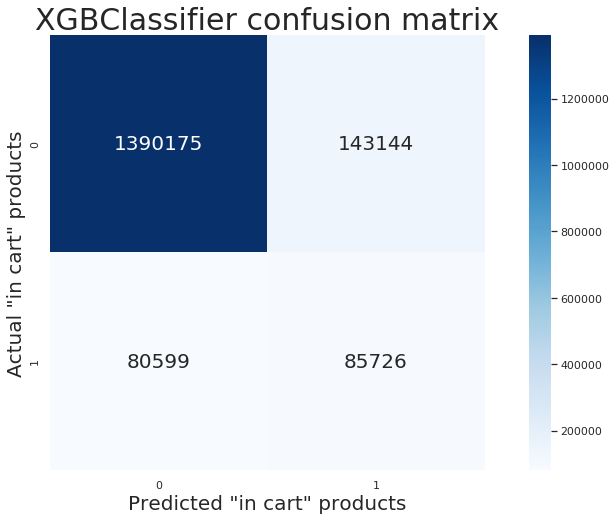

In [62]:
# Print confusion matrix for xgb
xgb_confusion = confusion_matrix(y_te, xgb.predict(X_te, ntree_limit=xgb.best_ntree_limit))

plt.figure(figsize=(16,8))
ax=sns.heatmap(xgb_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d', annot_kws={"size": 20})
plt.xlabel('Predicted "in cart" products', fontsize=20)
plt.ylabel('Actual "in cart" products', fontsize=20)
plt.title('XGBClassifier confusion matrix', fontsize=30);

## Feature importance

('u_p_orders_since_last_purch', 0.39366215) 

('u_p_total_orders', 0.26071844) 

('u_p_order_rate', 0.17531893) 

('p_reorder_rate', 0.036736142) 

('u_p_in_last_order', 0.025503324) 

('u_total_orders', 0.014206914) 

('u_total_products', 0.0128417825) 

('p_total_orders', 0.011072572) 

('a_reorder_rate', 0.010418799) 

('d_reorder_rate', 0.009356504) 

('u_avg_cartsize', 0.008923023) 

('u_avg_days_since_prior_order', 0.0072776284) 

('p_avg_add_cart_order', 0.0062697674) 

('u_d_order_rate', 0.005457306) 

('u_p_delta_dow', 0.0053222957) 

('u_p_delta_hour', 0.0044553108) 

('u_p_avg_add_to_cart_order', 0.004291707) 

('p_delta_dow', 0.0041780877) 

('p_delta_hour', 0.0039892937) 



([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text yticklabel objects>)

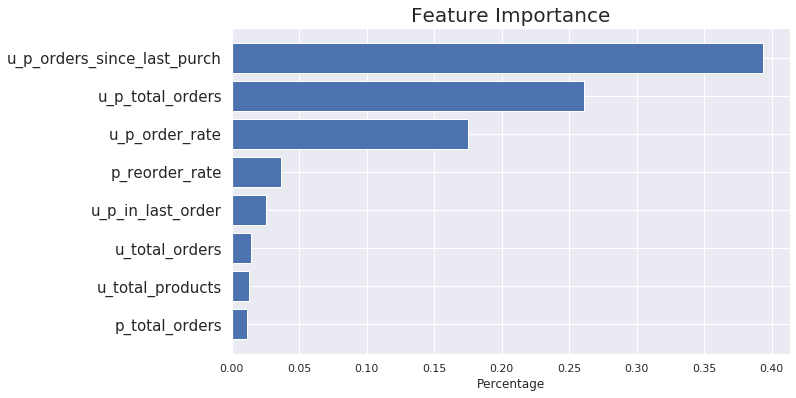

In [61]:
f_imp = zip(X_te.columns, xgb.feature_importances_)
f_imp = sorted(f_imp, key=lambda x: x[1], reverse=True)
for i in f_imp:
    print(i, '\n')

df = pd.DataFrame(list(f_imp), columns=['f', 'fe']).head(
    8).sort_values(by='fe')
plt.figure(figsize=(10, 6))
plt.barh(df.f, df.fe)
plt.title('Feature Importance', fontsize=20)
plt.xlabel('Percentage')
plt.yticks(fontsize=15)